#Présentation et organisation du notebook : 

Le notebook est divisé en sept grandes parties : 
*   **Step 1 :** On commence par récupérer les données et les tester pour mieux s'apprivoiser et visualiser les données audio, ce sont les données qu'on va utiliser dans les *step 2, step 3 et step 4 *
* **Step 2 :** On construit les descripteurs pour les données audio fournies les MFCC et les chromas afin de comprendre ce que représentent ces features 
* **Step 3 :** On commence par construire un classifieur binaire afin de tester sur les MFCC des données compositeurs pour Beethoven et Liszt (le but étant de pouvoir classifier puis analyser les erreurs) 
* **Step 4 :** On applique le classifieur cette fois pour les 4 compositeurs et on regarde ses performances 
* **Step 5 :** On s'intéresse à un nouveau daatset le MSDI_dataset, on applique trois stratégies : 
  - MFCC auquel on applique la régression logistique ; 
  - MFCC auquel on applique un modèle CNN 
  - On utilise les représentations apprises pour pouvoir avoir un système multi-modal 



#Initialisation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20, 10
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 15
mpl.rcParams['axes.grid'] = True
# mpl.rcParams.find_all('')

#Step 1: On récupère les données 

Données sons 4 dossiers:
- Liszt : 22 morceaux de 30 secondes ==> piano (style plus lyrique) 
- Mozart : 24 morceaux de 30 secondes ==> piano (assez rythmé)
- Chopin : 56 morceaux de 30 secondes ==> piano (style plus doux et espacé) 
- Beethoven : 18 morceaux de 30 secondes ==> piano (style plus grave) 


Spectrogrammes pour Beethoven : 

In [7]:
from sam_tf import compute_stft, show_spectrogram
from sam_utils import plot_sound, plot_spectrum, db, add_noise, snr
from sam_io import read_wav, write_wav
sound_path_beethoven = Path('data/beethoven/')


In [ ]:
!ls data/beethoven

MAPS_MUS-appass_1_AkPnBsdf.wav	    MAPS_MUS-pathetique_1_SptkBGCl.wav
MAPS_MUS-appass_1_SptkBGCl.wav	    MAPS_MUS-pathetique_1_StbgTGd2.wav
MAPS_MUS-appass_3_AkPnStgb.wav	    MAPS_MUS-pathetique_2_ENSTDkAm.wav
MAPS_MUS-mond_1_AkPnBsdf.wav	    MAPS_MUS-pathetique_3_ENSTDkAm.wav
MAPS_MUS-mond_1_SptkBGAm.wav	    MAPS_MUS-waldstein_1_AkPnBsdf.wav
MAPS_MUS-mond_2_SptkBGAm.wav	    MAPS_MUS-waldstein_1_AkPnStgb.wav
MAPS_MUS-mond_2_SptkBGCl.wav	    MAPS_MUS-waldstein_1_ENSTDkAm.wav
MAPS_MUS-mond_3_AkPnStgb.wav	    MAPS_MUS-waldstein_2_AkPnCGdD.wav
MAPS_MUS-pathetique_1_ENSTDkCl.wav  MAPS_MUS-waldstein_3_SptkBGCl.wav


(0.0, 8000.0)

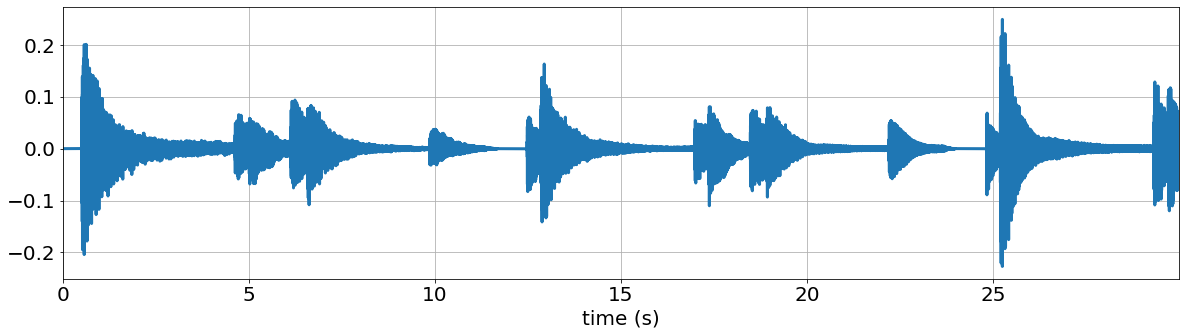

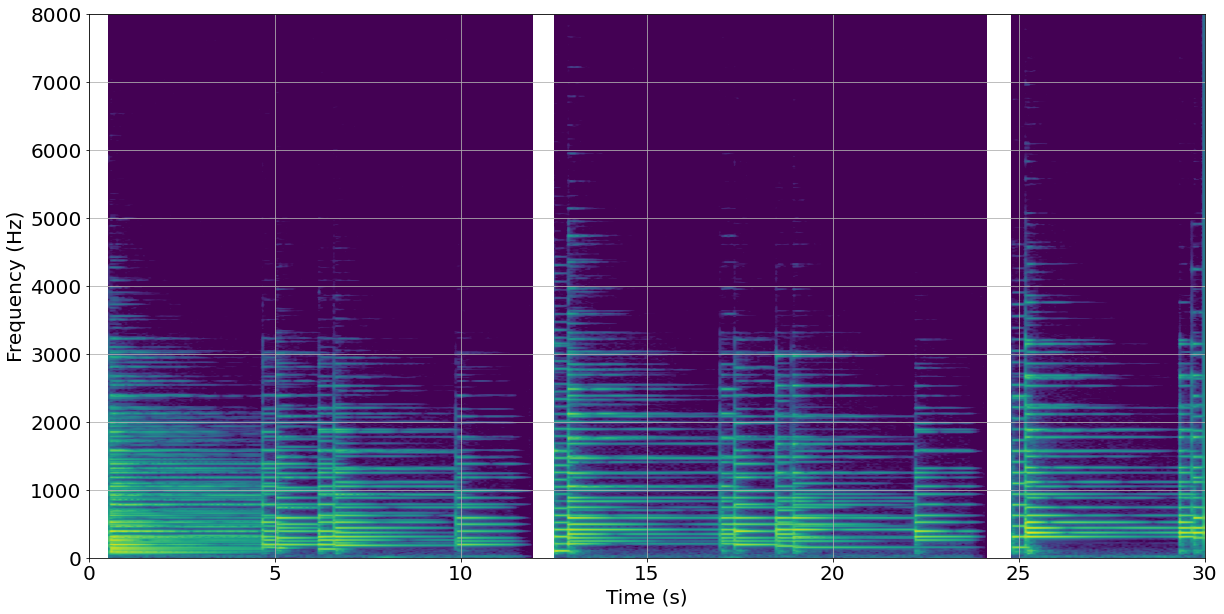

In [ ]:
sound_file = sound_path_beethoven / 'MAPS_MUS-pathetique_1_SptkBGCl.wav'
fs, x = read_wav(sound_file) #read_wav convertit le fichier en float entre [-1,1]

stft_params = {
    'seg_dur': 0.1,
    'nfft': None,
    'overlap_ratio':0.2,
    'window': 'hann',
}
f, t, X = compute_stft(x, fs, **stft_params)

plt.figure(figsize=(20, 5))
plot_sound(x, fs)
plt.xlim(0, (x.size-1)/fs)

plt.figure()
show_spectrogram(f, t, X)
plt.ylim(0, 8000)


In [ ]:
print(fs)
print(x.shape)

44100
(1323000,)


(0.0, 8000.0)

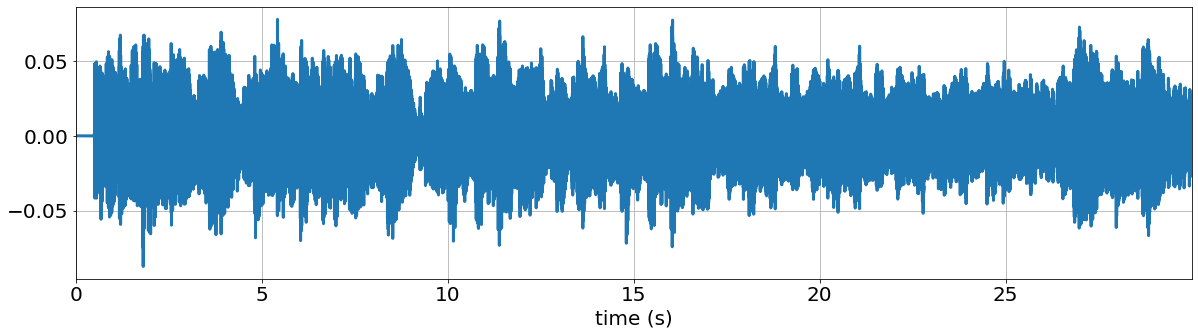

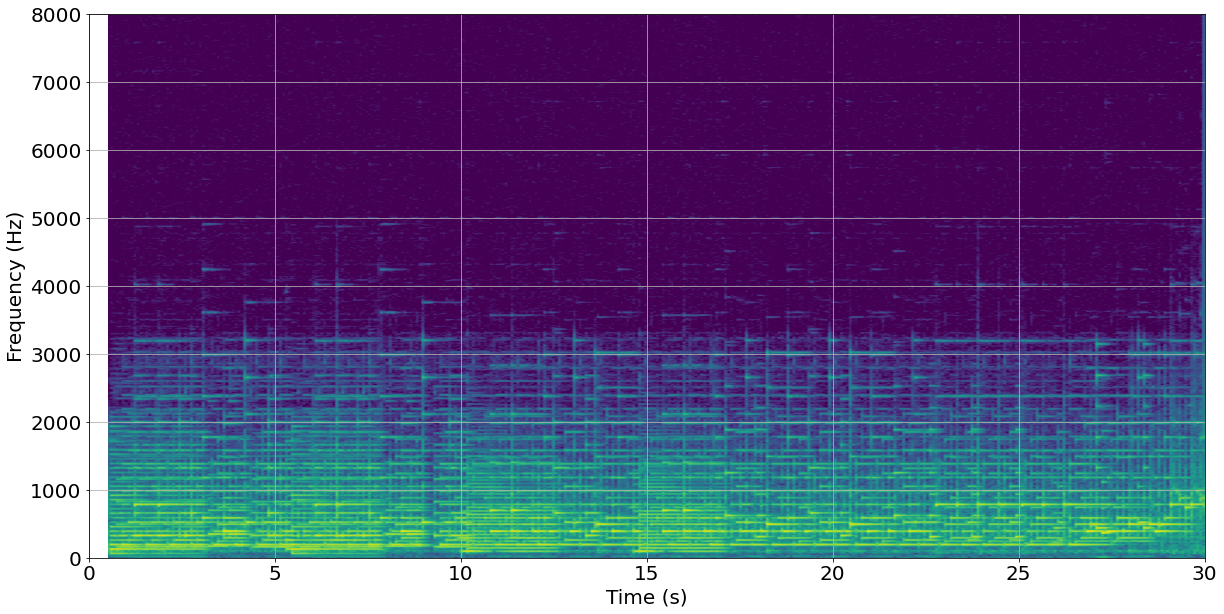

In [ ]:
sound_file = sound_path_beethoven / 'MAPS_MUS-waldstein_3_SptkBGCl.wav'
fs, x = read_wav(sound_file) #read_wav convertit le fichier en float entre [-1,1]

stft_params = {
    'seg_dur': 0.1,
    'nfft': None,
    'overlap_ratio':0.2,
    'window': 'hann',
}
f, t, X = compute_stft(x, fs, **stft_params)

plt.figure(figsize=(20, 5))
plot_sound(x, fs)
plt.xlim(0, (x.size-1)/fs)

plt.figure()
show_spectrogram(f, t, X)
plt.ylim(0, 8000)

In [ ]:
print(fs)
print(x)
print(len(x))

44100
[0.         0.         0.         ... 0.012146   0.0112915  0.01016235]
1323000


Remarque sur les spectrogrammes des deux fichiers : 
- Dans le fichier **MAPS_MUS-pathetique_1_SptkBGCl.wav** : à l'écoute on entends plusieurs notes mais il y'a un temps qui sépare chaque note. La mélodie n'est pas rapide. On retrouve bien ces variations sur le spectrogramme : le son a le temps de mourir et les notes sont bien distinctes. 
A l'oreille on peut dire qu'on distingue 6 notes différentes qu'on répète,on peut retrouver cette allure sur le spectre du signal
- Dans le fichier **MAPS_MUS-waldstein_3_SptkBGCl.wav** : la mélodie est plus rapide, on a plus de mal à distinguer les notes entre elles. Elles se recouvrent. C'est une information qu'on retrouve sur le spectrogramme qui est très diffus. 

#Step 2: On construit les descripteurs pour nos données == features : MFCC et Chromas 

##Les chromas : 
* Bonne interprétabilité: reflète grossièrement la présence de chaque note dans une trame

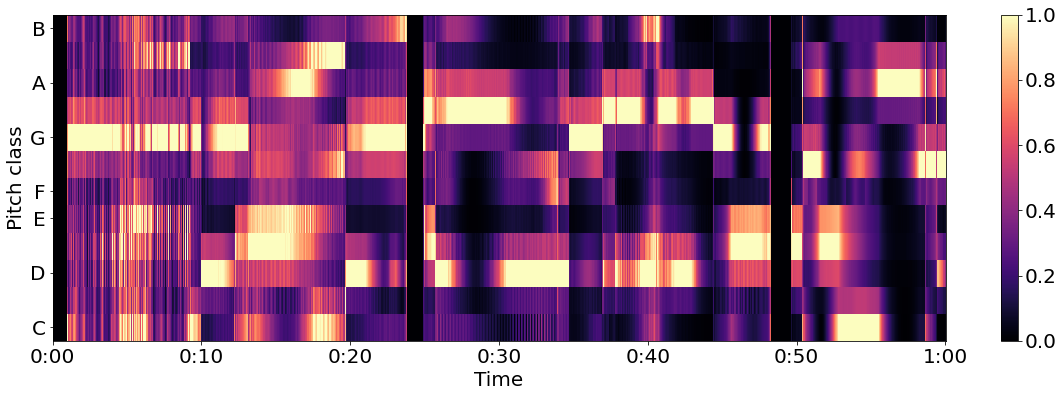

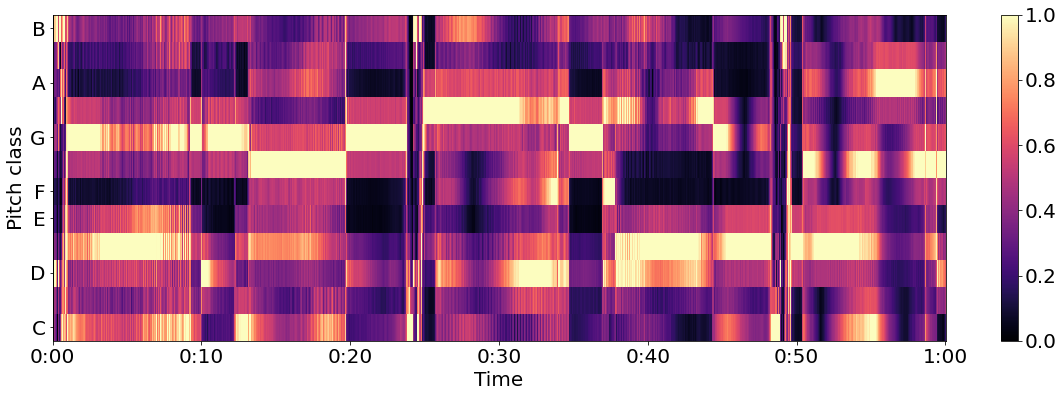

In [ ]:
from librosa.feature import chroma_stft, chroma_cqt
from librosa.display import specshow

sound_file =  sound_path_beethoven / 'MAPS_MUS-pathetique_1_SptkBGCl.wav'
fs, x = read_wav(sound_file)

plt.figure(figsize=(20,6))
c_stft = chroma_stft(x, fs)
specshow(c_stft, y_axis='chroma', x_axis='time')
plt.colorbar()

plt.figure(figsize=(20,6))
c_cqt = chroma_cqt(x, fs)
specshow(c_cqt, y_axis='chroma', x_axis='time')
plt.colorbar()



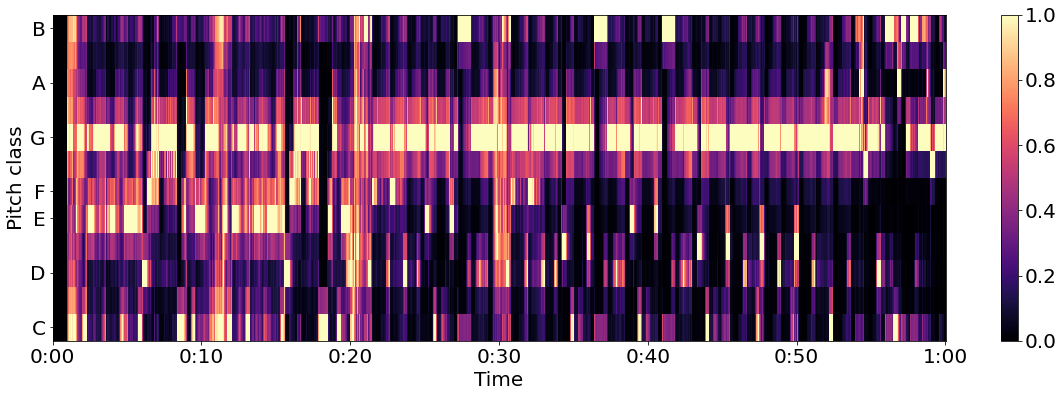

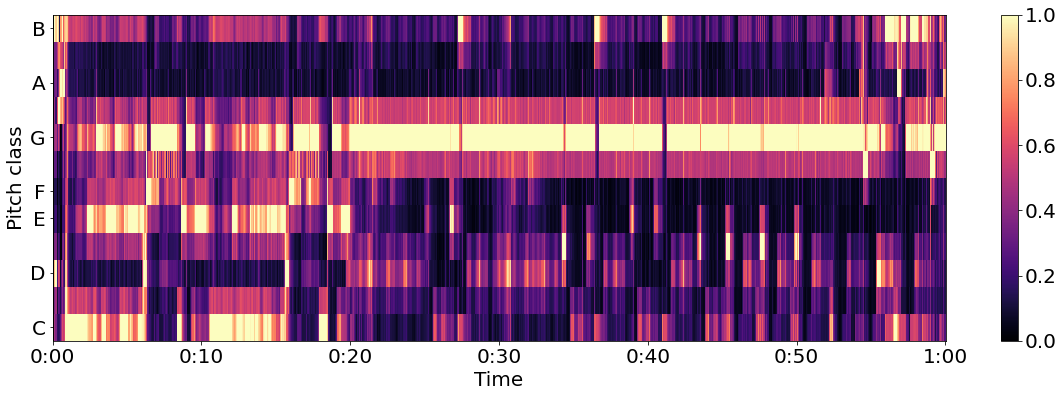

In [ ]:
sound_file = sound_path_beethoven / 'MAPS_MUS-waldstein_3_SptkBGCl.wav'
fs, x = read_wav(sound_file)

plt.figure(figsize=(20,6))
c_stft = chroma_stft(x, fs)
specshow(c_stft, y_axis='chroma', x_axis='time')
plt.colorbar()

plt.figure(figsize=(20,6))
c_cqt = chroma_cqt(x, fs)
specshow(c_cqt, y_axis='chroma', x_axis='time')
plt.colorbar()

Quelle est la différence pour l'interprétabilité entre chroma_stft et chroma_cqt ? 
les deux me permettent de voir combien d'énergie on a pour chaque "pitch class"= descripteur pour chord recognition, donc pour ça ils sont porteurs des mms informations. Après les mfccs sont peut-être plus visuels et facile à interpréter 

Pour revenir aux premières remarques : 
- **MAPS_MUS-pathetique_1_SptkBGCl.wav** : on distingue les notes par octave, il y'en a une principale à chaque pitch class et période 
- **MAPS_MUS-waldstein_3_SptkBGCl.wav** : ici c'est plus diffus et y'a plus de notes par octave = ca traduit le recouvrement des notes entre elles qu'on a remarqué au début 


##MFCC : 

* Représentation compacte: très peu de coefficients pour décrire la forme du spectre.
* Faible interprétabilité, censé bien représenter les caractéristiques sources/filtre.

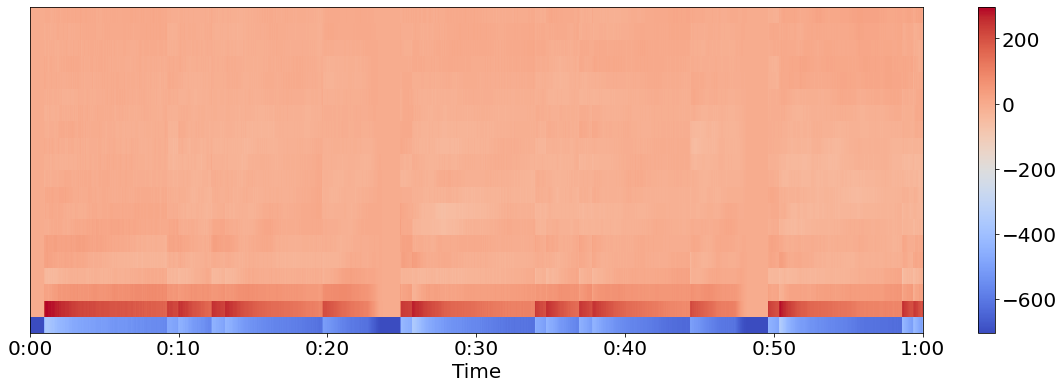

In [ ]:
from librosa.feature import mfcc

sound_file =  sound_path_beethoven / 'MAPS_MUS-pathetique_1_SptkBGCl.wav'
fs, x = read_wav(sound_file)

plt.figure(figsize=(20,6))
x_mfcc = mfcc(x, fs)
specshow(x_mfcc, x_axis='time')
plt.colorbar()

In [ ]:
print(x_mfcc.shape)

(20, 2584)


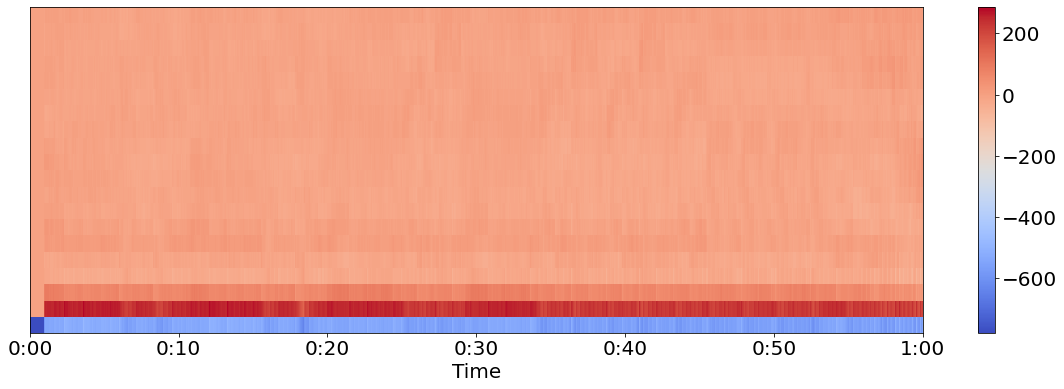

In [ ]:
sound_file = sound_path_beethoven / 'MAPS_MUS-waldstein_3_SptkBGCl.wav'
fs, x = read_wav(sound_file)
x = x#[:13*fs]
plt.figure(figsize=(20,6))
x_mfcc = mfcc(x, fs)
specshow(x_mfcc, x_axis='time')
plt.colorbar()

# Step 3 : Classifieur de compositeurs pour Beethoven et Liszt seulement

On va d'abord essayer de classifier beethoven et Liszt en se disant que c'est deux styles de piano très différents 

In [ ]:
!ls data/liszt

MAPS_MUS-liz_et1_SptkBGAm.wav	     MAPS_MUS-liz_et_trans5_AkPnCGdD.wav
MAPS_MUS-liz_et2_AkPnStgb.wav	     MAPS_MUS-liz_et_trans5_ENSTDkCl.wav
MAPS_MUS-liz_et2_SptkBGAm.wav	     MAPS_MUS-liz_et_trans5_StbgTGd2.wav
MAPS_MUS-liz_et3_AkPnStgb.wav	     MAPS_MUS-liz_rhap02_AkPnCGdD.wav
MAPS_MUS-liz_et4_SptkBGCl.wav	     MAPS_MUS-liz_rhap02_ENSTDkAm.wav
MAPS_MUS-liz_et5_AkPnCGdD.wav	     MAPS_MUS-liz_rhap09_ENSTDkAm.wav
MAPS_MUS-liz_et6_AkPnBsdf.wav	     MAPS_MUS-liz_rhap09_ENSTDkCl.wav
MAPS_MUS-liz_et6_AkPnCGdD.wav	     MAPS_MUS-liz_rhap09_SptkBGCl.wav
MAPS_MUS-liz_et6_ENSTDkCl.wav	     MAPS_MUS-liz_rhap09_StbgTGd2.wav
MAPS_MUS-liz_et6_StbgTGd2.wav	     MAPS_MUS-liz_rhap10_AkPnBsdf.wav
MAPS_MUS-liz_et_trans4_SptkBGAm.wav  MAPS_MUS-liz_rhap12_ENSTDkAm.wav


In [8]:
sound_path_liszt = Path('data/liszt/')

beethoven_files = ['MAPS_MUS-appass_1_AkPnBsdf.wav',
                   'MAPS_MUS-pathetique_1_SptkBGCl.wav',
                   'MAPS_MUS-appass_1_SptkBGCl.wav',	    
                   'MAPS_MUS-pathetique_1_StbgTGd2.wav',
                   'MAPS_MUS-appass_3_AkPnStgb.wav',
                   'MAPS_MUS-pathetique_2_ENSTDkAm.wav',
                   'MAPS_MUS-mond_1_AkPnBsdf.wav',
                   'MAPS_MUS-pathetique_3_ENSTDkAm.wav',
                   'MAPS_MUS-mond_1_SptkBGAm.wav',
                   'MAPS_MUS-waldstein_1_AkPnBsdf.wav',
                   'MAPS_MUS-mond_2_SptkBGAm.wav',
                   'MAPS_MUS-waldstein_1_AkPnStgb.wav',
                   'MAPS_MUS-mond_2_SptkBGCl.wav',
                   'MAPS_MUS-waldstein_1_ENSTDkAm.wav',
                   'MAPS_MUS-mond_3_AkPnStgb.wav',
                   'MAPS_MUS-waldstein_2_AkPnCGdD.wav',
                   'MAPS_MUS-pathetique_1_ENSTDkCl.wav',
                   'MAPS_MUS-waldstein_3_SptkBGCl.wav' ]

liszt_files = ['MAPS_MUS-liz_et1_SptkBGAm.wav'	,     'MAPS_MUS-liz_et_trans5_AkPnCGdD.wav',
'MAPS_MUS-liz_et2_AkPnStgb.wav',	     'MAPS_MUS-liz_et_trans5_ENSTDkCl.wav',
'MAPS_MUS-liz_et2_SptkBGAm.wav',	     'MAPS_MUS-liz_et_trans5_StbgTGd2.wav',
'MAPS_MUS-liz_et3_AkPnStgb.wav',	     'MAPS_MUS-liz_rhap02_AkPnCGdD.wav',
'MAPS_MUS-liz_et4_SptkBGCl.wav',	     'MAPS_MUS-liz_rhap02_ENSTDkAm.wav',
'MAPS_MUS-liz_et5_AkPnCGdD.wav',	     'MAPS_MUS-liz_rhap09_ENSTDkAm.wav',
'MAPS_MUS-liz_et6_AkPnBsdf.wav',	     'MAPS_MUS-liz_rhap09_ENSTDkCl.wav',
'MAPS_MUS-liz_et6_AkPnCGdD.wav',	     'MAPS_MUS-liz_rhap09_SptkBGCl.wav',
'MAPS_MUS-liz_et6_ENSTDkCl.wav',	     'MAPS_MUS-liz_rhap09_StbgTGd2.wav',
'MAPS_MUS-liz_et6_StbgTGd2.wav',	     'MAPS_MUS-liz_rhap10_AkPnBsdf.wav',
'MAPS_MUS-liz_et_trans4_SptkBGAm.wav',  'MAPS_MUS-liz_rhap12_ENSTDkAm.wav' ]

In [9]:
n_files = len(beethoven_files)+len(liszt_files)
fs = np.zeros(n_files)
x = np.zeros((n_files,1323000))

for i in range (len(beethoven_files)):
  sound_file = sound_path_beethoven / beethoven_files[i]
  fs[i] = read_wav(sound_file)[0]
  x[i] = read_wav(sound_file)[1]


for i in range (len(beethoven_files),n_files):
  sound_file = sound_path_liszt / liszt_files[i-len(beethoven_files)]
  fs[i] = read_wav(sound_file)[0]
  x[i] = read_wav(sound_file)[1]


In [ ]:
#on regarde deux sepctrogrammes random
stft_params = {
    'seg_dur': 0.1,
    'nfft': None,
    'overlap_ratio':0.2,
    'window': 'hann',
}

a,b = np.random.randint(n_files),np.random.randint(n_files)

f, t, X = compute_stft(x[a], fs[a], **stft_params)

plt.figure(figsize=(20, 5))
plot_sound(x[a], fs[a])
plt.xlim(0, (x[a].size-1)/fs[a])

plt.figure()
show_spectrogram(f, t, X)
plt.ylim(0, 8000)
plt.title('spectrogramme pour le fichier audio n° %s.' %a)

f1, t1, X1 = compute_stft(x[b], fs[b], **stft_params)

plt.figure(figsize=(20, 5))
plot_sound(x[b], fs[b])
plt.xlim(0, (x[b].size-1)/fs[b])

plt.figure()
show_spectrogram(f1, t1, X1)
plt.ylim(0, 8000)
plt.title('spectrogramme pour le fichier audio n° %s.' %b)

Output hidden; open in https://colab.research.google.com to view.

On va faire une fonction pour les features (pour l'instant on prend MFCC)

###MFCC

In [10]:
from librosa.feature import mfcc

def mfcc_feature(x,fs) : 
  return mfcc(x, fs)

Text(0.5, 1.0, 'MFCCs pour le fichier audio n° 31.')

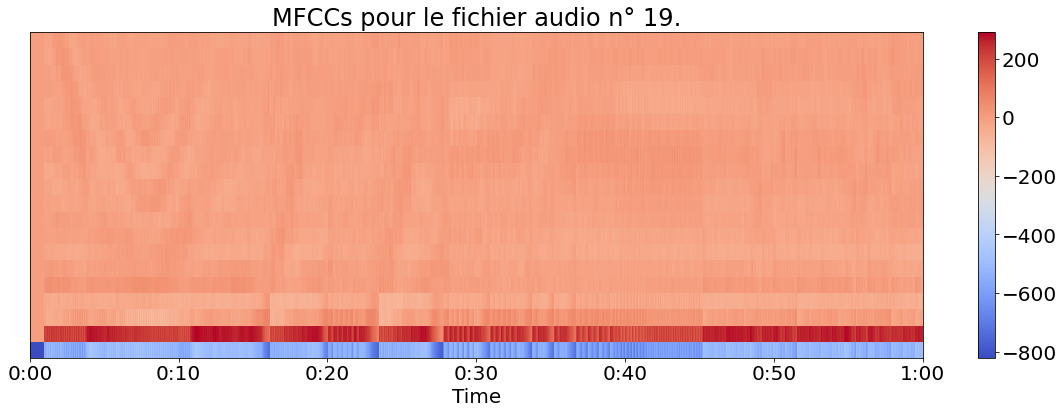

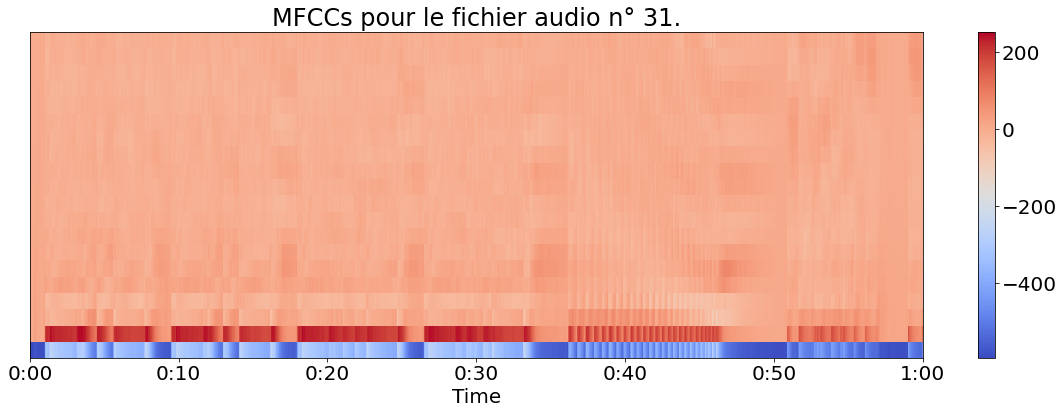

In [ ]:
#ON peut visualiser sur les deux exemples a et b 

fs_a,fs_b = fs[a],fs[b]
x_a, x_b = x[a],x[b]

x_a_mfcc,x_b_mfcc = mfcc_feature(x_a,fs_a), mfcc_feature(x_b,fs_b)

plt.figure(figsize=(20,6))
specshow(x_a_mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCCs pour le fichier audio n° %s.' %a)

plt.figure(figsize=(20,6))
specshow(x_b_mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCCs pour le fichier audio n° %s.' %b)

In [11]:
labels = ['Beethoven']*len(beethoven_files)+['Liszt']*len(liszt_files) #0 pour Beethoven et 1 pour Liszt 
data = []

for i in range(len(beethoven_files)): 
  data.append(mfcc_feature(x[i],fs[i])) #beethoven

for i in range(len(beethoven_files),n_files): 
  data.append(mfcc_feature(x[i],fs[i])) #liszt

In [ ]:
X = np.array(data)
Y = np.array(labels)

#on doit transformer Y dans le bon format 
from sklearn.preprocessing import LabelEncoder 
from keras.utils import to_categorical 
le = LabelEncoder()
Y_transformed = to_categorical(le.fit_transform(Y))

#il faut qu'on split en train et test 
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y_transformed,test_size=0.3)

num_rows = X.shape[1]
num_columns = X.shape[2]
num_channels = 1 #pour multimodal il y'a ca qui change 

#c'est jjuste pour rajouter le nombre de channels 
X_train = X_train.reshape(X_train.shape[0],num_rows,num_columns,num_channels)
X_test = X_test.reshape(X_test.shape[0],num_rows,num_columns,num_channels)

num_labels = Y_transformed.shape[1] #la j'en ai que deux parce que je travaille que sur Beethoven et Liszt 
filter_size = 2

print((num_rows,num_columns,num_channels))
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(20, 2584, 1)
(28, 20, 2584, 1)
(12, 20, 2584, 1)
(28, 2)
(12, 2)


## CNN Classifier

In [ ]:
#construire le modèle 
from keras.models import Sequential 
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from keras.optimizers import Adam
from keras.utils import np_utils 
from sklearn import metrics

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2 ,input_shape=(num_rows,num_columns,num_channels),activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2 ,activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2 ,activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(num_labels,activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 4999, 11, 16)      80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2499, 5, 16)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2499, 5, 16)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2498, 4, 32)       2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1249, 2, 32)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1249, 2, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1248, 1, 64)      

In [ ]:
num_epochs = 30
num_batch = 200 

model.fit(X_train,Y_train,batch_size=num_batch,epochs=num_epochs,validation_data=(X_test,Y_test))

Epoch 1/30
1/1 [==============================] - 0s 264ms/step - loss: 16.5054 - accuracy: 0.4643 - val_loss: 184.5178 - val_accuracy: 0.3333
Epoch 2/30
1/1 [==============================] - 0s 117ms/step - loss: 270.7725 - accuracy: 0.5000 - val_loss: 137.0594 - val_accuracy: 0.3333
Epoch 3/30
1/1 [==============================] - 0s 128ms/step - loss: 207.0497 - accuracy: 0.5000 - val_loss: 49.5164 - val_accuracy: 0.3333
Epoch 4/30
1/1 [==============================] - 0s 119ms/step - loss: 77.7986 - accuracy: 0.5000 - val_loss: 19.5184 - val_accuracy: 0.6667
Epoch 5/30
1/1 [==============================] - 0s 113ms/step - loss: 52.1379 - accuracy: 0.5000 - val_loss: 33.2178 - val_accuracy: 0.6667
Epoch 6/30
1/1 [==============================] - 0s 114ms/step - loss: 85.0300 - accuracy: 0.5000 - val_loss: 30.5118 - val_accuracy: 0.6667
Epoch 7/30
1/1 [==============================] - 0s 114ms/step - loss: 87.2693 - accuracy: 0.5000 - val_loss: 20.2116 - val_accuracy: 0.6667
Ep

In [ ]:
score = model.evaluate(X_test,Y_test)
print('Accuracy %s.' %score[1])

1/1 [==============================] - 0s 1ms/step - loss: 0.7223 - accuracy: 0.7500
Accuracy 0.75.


C'est une classification binaire, sur 30 epochs mon CNN a une accuracy de 0,75. \\
Si j'augmente le nombre d'epochs l'accuracy augmente fortement jusqu'à atteindre de 0,83 ce qui est pas mal :) Bon c'est normal, mon dataset n'est pas fourni .

On peut regarder un exemple de quand il se trompe pour mieux comprendre comment il fonctionne. 
CNN est efficace pour ma classification binaire, essayons maintenant pour tous les compositeurs ==> mes labels vont contenir 4 classes 

In [ ]:
import pandas as pd 
results = model.predict(X_test)
results = [np.argmax(result) for result in results]
print(len(results)) 
# print(Y_test[:,1])

indices_errors= [] #il va contenir les indices de là ou on s'est trompé, je ne sais pas combien il y'a de false samples
for i in range(len(results)):
  if results[i] != Y_test[i,1] : #je prend que la première colonee de Y_test parce qu'on l'avait modifié avant pour qu'on puisse le meyyre au bonformat pour le CNN
    indices_errors.append(i)

print(indices_errors)

12
[1, 4, 6]


Text(0.5, 1.0, 'MFCCs pour le fichier audio n° 4.')

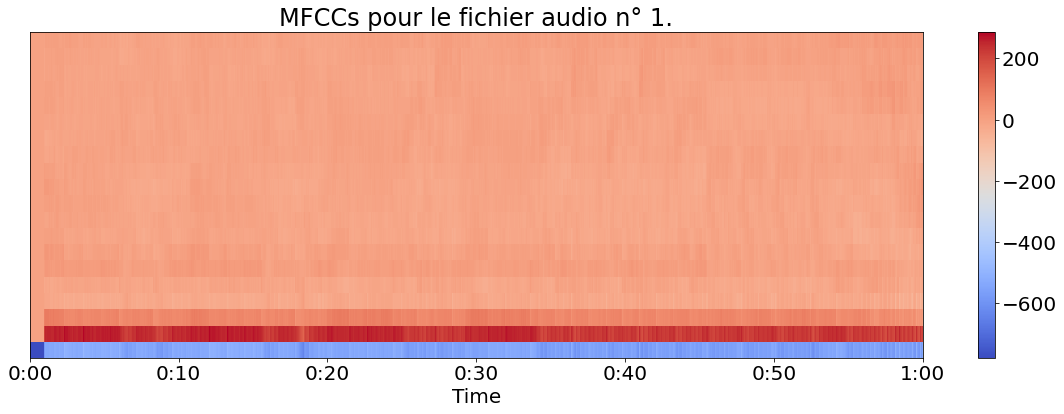

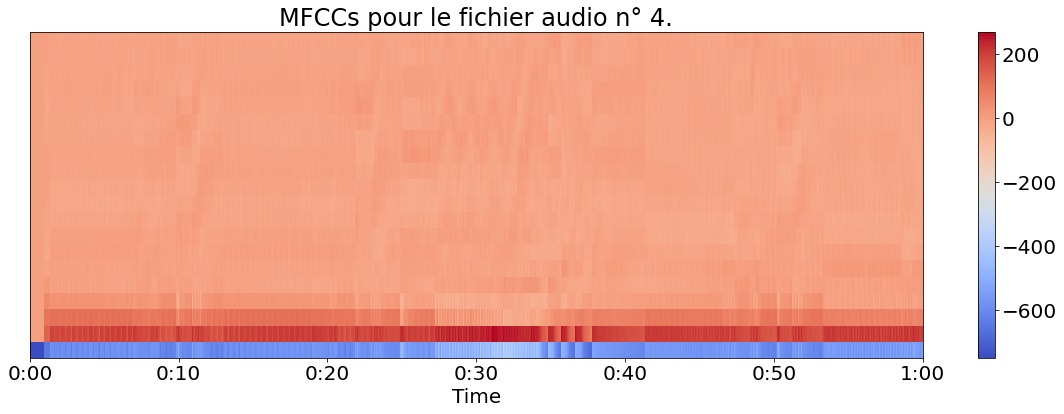

In [ ]:
a,b = indices_errors[0],indices_errors[1]

x_a_mfcc,x_b_mfcc = X_test[a][:,:,0], X_test[b][:,:,0] #on récupère la data de là où il s'est trompé 

plt.figure(figsize=(20,6))
specshow(x_a_mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCCs pour le fichier audio n° %s.' %a)

plt.figure(figsize=(20,6))
specshow(x_b_mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCCs pour le fichier audio n° %s.' %b)

#matrice de confusion pour voir ce qui ne va pas  

**Remarque :** 

J'aurai aimé pouvoir accéder au spectrogramme pour recréer le son et écouter les deux fichiers où il s'est trompé et voir si par exemple à l'écoute on pourrait confondre beethoven et liszt. Malheureusement je n'y arrive pas pour le moment. Je trouve ça difficile d'interpréter le mfcc pour justifier de l'erreur du modèle mais j'aurai essayé. 

# Step 4 : Classifieur de compositeurs pour l'ensemble des compositeurs  

In [12]:
sound_path_mozart = Path('data/mozart/')
sound_path_chopin = Path('data/chopin/')

mozart_files = ['MAPS_MUS-mz_311_1_ENSTDkCl.wav',	'MAPS_MUS-mz_332_2_ENSTDkCl.wav',
'MAPS_MUS-mz_311_1_StbgTGd2.wav',	'MAPS_MUS-mz_332_2_StbgTGd2.wav',
'MAPS_MUS-mz_330_1_SptkBGCl.wav'	,'MAPS_MUS-mz_333_1_AkPnStgb.wav',
'MAPS_MUS-mz_331_1_SptkBGCl.wav'	,'MAPS_MUS-mz_333_2_AkPnCGdD.wav',
'MAPS_MUS-mz_331_2_AkPnBcht.wav'	,'MAPS_MUS-mz_333_2_ENSTDkCl.wav',
'MAPS_MUS-mz_331_2_AkPnBsdf.wav',	'MAPS_MUS-mz_333_2_StbgTGd2.wav',
'MAPS_MUS-mz_331_2_ENSTDkCl.wav',	'MAPS_MUS-mz_333_3_ENSTDkCl.wav',
'MAPS_MUS-mz_331_2_StbgTGd2.wav',	'MAPS_MUS-mz_333_3_StbgTGd2.wav',
'MAPS_MUS-mz_331_3_AkPnBsdf.wav',	'MAPS_MUS-mz_545_3_ENSTDkCl.wav',
'MAPS_MUS-mz_331_3_ENSTDkCl.wav',	'MAPS_MUS-mz_545_3_StbgTGd2.wav',
'MAPS_MUS-mz_331_3_StbgTGd2.wav',	'MAPS_MUS-mz_570_1_ENSTDkCl.wav',
'MAPS_MUS-mz_332_1_AkPnBsdf.wav',	'MAPS_MUS-mz_570_1_StbgTGd2.wav']

chopin_files = ['MAPS_MUS-chpn-e01_ENSTDkCl.wav','MAPS_MUS-chpn-p14_AkPnBcht.wav',
'MAPS_MUS-chpn-e01_SptkBGAm.wav',		'MAPS_MUS-chpn-p14_AkPnCGdD.wav',
'MAPS_MUS-chpn-e01_StbgTGd2.wav',		'MAPS_MUS-chpn-p14_ENSTDkAm.wav',
'MAPS_MUS-chpn_op10_e01_AkPnCGdD.wav',	'MAPS_MUS-chpn-p15_AkPnCGdD.wav',
'MAPS_MUS-chpn_op10_e05_SptkBGAm.wav',	'MAPS_MUS-chpn-p15_ENSTDkAm.wav',
'MAPS_MUS-chpn_op10_e12_AkPnCGdD.wav',	'MAPS_MUS-chpn-p16_AkPnStgb.wav',
'MAPS_MUS-chpn_op25_e2_AkPnBcht.wav',	'MAPS_MUS-chpn-p19_AkPnBsdf.wav',
'MAPS_MUS-chpn_op25_e3_ENSTDkAm.wav',	'MAPS_MUS-chpn-p19_ENSTDkCl.wav',
'MAPS_MUS-chpn_op25_e3_SptkBGAm.wav',	'MAPS_MUS-chpn-p19_StbgTGd2.wav',
'MAPS_MUS-chpn_op25_e4_ENSTDkAm.wav',	'MAPS_MUS-chpn-p1_AkPnBcht.wav',
'MAPS_MUS-chpn_op27_1_AkPnCGdD.wav',	'MAPS_MUS-chpn-p1_AkPnBsdf.wav',
'MAPS_MUS-chpn_op27_2_AkPnStgb.wav',	'MAPS_MUS-chpn-p20_AkPnCGdD.wav',
'MAPS_MUS-chpn_op27_2_SptkBGCl.wav',	'MAPS_MUS-chpn-p21_AkPnBsdf.wav',
'MAPS_MUS-chpn_op33_2_ENSTDkAm.wav',	'MAPS_MUS-chpn-p24_AkPnBcht.wav',
'MAPS_MUS-chpn_op33_2_SptkBGAm.wav',	'MAPS_MUS-chpn-p2_SptkBGCl.wav',
'MAPS_MUS-chpn_op33_4_SptkBGAm.wav',	'MAPS_MUS-chpn-p3_AkPnBcht.wav',
'MAPS_MUS-chpn_op35_1_ENSTDkAm.wav',	'MAPS_MUS-chpn-p4_AkPnBcht.wav',
'MAPS_MUS-chpn_op35_3_AkPnStgb.wav',	'MAPS_MUS-chpn-p4_AkPnBsdf.wav',
'MAPS_MUS-chpn_op66_AkPnBcht.wav',		'MAPS_MUS-chpn-p4_ENSTDkAm.wav',
'MAPS_MUS-chpn_op66_ENSTDkAm.wav',		'MAPS_MUS-chpn-p6_SptkBGAm.wav',
'MAPS_MUS-chpn_op7_1_ENSTDkAm.wav',	'MAPS_MUS-chpn-p6_SptkBGCl.wav',
'MAPS_MUS-chpn_op7_2_SptkBGAm.wav',	'MAPS_MUS-chpn-p7_AkPnCGdD.wav',
'MAPS_MUS-chpn-p10_AkPnStgb.wav',		'MAPS_MUS-chpn-p7_SptkBGCl.wav',
'MAPS_MUS-chpn-p11_AkPnCGdD.wav',		'MAPS_MUS-chpn-p8_AkPnBcht.wav',
'MAPS_MUS-chpn-p11-format0_AkPnCGdD.wav',	'MAPS_MUS-chpn-p9_AkPnBsdf.wav',
'MAPS_MUS-chpn-p12_AkPnBcht.wav',		'MAPS_MUS-chp_op18_AkPnCGdD.wav',
'MAPS_MUS-chpn-p13_AkPnBcht.wav',		'MAPS_MUS-chp_op31_AkPnBcht.wav',
'MAPS_MUS-chpn-p13_AkPnCGdD.wav',		'MAPS_MUS-chp_op31_AkPnStgb.wav'
]

In [13]:
n = len(chopin_files)+len(mozart_files)
n_files += n 
fs_1 = np.zeros(n)
x_1= np.zeros((n,1323000))

for i in range (len(mozart_files)):
  sound_file = sound_path_mozart / mozart_files[i]
  fs_1[i] = read_wav(sound_file)[0]
  x_1[i] = read_wav(sound_file)[1]

for i in range (len(mozart_files), n):
  sound_file = sound_path_chopin / chopin_files[i - len(mozart_files)]
  fs_1[i] = read_wav(sound_file)[0]
  if read_wav(sound_file)[1].shape == 1323000 : 
    x_1[i] = read_wav(sound_file)[1]
  else :  #Quand c'est pas le bon shape pour x je complète par des zeros 
    z = np.zeros(1323000) 
    index = read_wav(sound_file)[1].shape[0]
    z[0:index] = read_wav(sound_file)[1]
    x_1[i] = z 

In [14]:
fs_all = np.zeros(n_files)
x_all = np.zeros((n_files,1323000))

fs_all[:n_files-n] = fs 
fs_all[n_files-n:n_files] = fs_1 
x_all[:n_files-n] = x 
x_all[n_files-n:n_files]  = x_1
print(fs_all.shape)
print(x_all.shape)

(120,)
(120, 1323000)


In [15]:
labels += ['Mozart']*len(mozart_files)+['Chopin']*len(chopin_files) #2 pour Mozart et 3 pour Chopin 
n = len(beethoven_files)+len(liszt_files)

for i in range(n, n + len(mozart_files)): 
  data.append(mfcc_feature(x_all[i],fs_all[i])) #mozart

for i in range(n + len(mozart_files), n_files): 
  data.append(mfcc_feature(x_all[i],fs_all[i])) #chopin

In [ ]:
print(fs_all.shape)
print(x_all.shape)
print(len(data))
print(n_files)

(120,)
(120, 1323000)
120
120


In [16]:
X = np.array(data)
Y = np.array(labels)

#on doit transformer Y dans le bon format 
from sklearn.preprocessing import LabelEncoder 
from keras.utils import to_categorical 
le = LabelEncoder()
Y_transformed = to_categorical(le.fit_transform(Y))


#il faut qu'on split en train et test 
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y_transformed,test_size=0.3)

num_rows = X.shape[1]
num_columns = X.shape[2]
num_channels = 1 #pour multimodal il y'a ca qui change 

#c'est jjuste pour rajouter le nombre de channels 
X_train = X_train.reshape(X_train.shape[0],num_rows,num_columns,num_channels)
X_test = X_test.reshape(X_test.shape[0],num_rows,num_columns,num_channels)

num_labels = Y_transformed.shape[1] #la j'en ai que deux parce que je travaille que sur Beethoven et Liszt 
filter_size = 2

print((num_rows,num_columns,num_channels))
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(20, 2584, 1)
(84, 20, 2584, 1)
(36, 20, 2584, 1)
(84, 4)
(36, 4)


In [17]:
#construire le modèle 
from keras.models import Sequential 
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from keras.optimizers import Adam
from keras.utils import np_utils 
from sklearn import metrics

model_all = Sequential()
model_all.add(Conv2D(filters=16, kernel_size=2 ,input_shape=(num_rows,num_columns,num_channels),activation = 'relu'))
model_all.add(MaxPooling2D(pool_size=2))
model_all.add(Dropout(0.2))

model_all.add(Conv2D(filters=32, kernel_size=2 ,activation = 'relu'))
model_all.add(MaxPooling2D(pool_size=2))
model_all.add(Dropout(0.2))

model_all.add(Conv2D(filters=64, kernel_size=2 ,activation = 'relu'))
model_all.add(MaxPooling2D(pool_size=2))
model_all.add(Dropout(0.2))
model_all.add(Flatten())

model_all.add(Dense(num_labels,activation='softmax'))

In [18]:
model_all.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model_all.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 2583, 16)      80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 1291, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 1291, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 1290, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 645, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 645, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 644, 64)        8

In [22]:
num_epochs = 100
num_batch = 200 

model_all.fit(X_train,Y_train,batch_size=num_batch,epochs=num_epochs,validation_data=(X_test,Y_test))

Epoch 1/100
1/1 [==============================] - 0s 150ms/step - loss: 1.0961 - accuracy: 0.6071 - val_loss: 1.1751 - val_accuracy: 0.5833
Epoch 2/100
1/1 [==============================] - 0s 110ms/step - loss: 1.2652 - accuracy: 0.5595 - val_loss: 1.1612 - val_accuracy: 0.6111
Epoch 3/100
1/1 [==============================] - 0s 109ms/step - loss: 1.1154 - accuracy: 0.6190 - val_loss: 1.1473 - val_accuracy: 0.6111
Epoch 4/100
1/1 [==============================] - 0s 96ms/step - loss: 0.9216 - accuracy: 0.6905 - val_loss: 1.1328 - val_accuracy: 0.6389
Epoch 5/100
1/1 [==============================] - 0s 99ms/step - loss: 1.0089 - accuracy: 0.6548 - val_loss: 1.1174 - val_accuracy: 0.6389
Epoch 6/100
1/1 [==============================] - 0s 95ms/step - loss: 0.8912 - accuracy: 0.7024 - val_loss: 1.1056 - val_accuracy: 0.6389
Epoch 7/100
1/1 [==============================] - 0s 98ms/step - loss: 1.1932 - accuracy: 0.5833 - val_loss: 1.0955 - val_accuracy: 0.6389
Epoch 8/100
1/1 [

**Remarque :**

Sans beaucoup de surprise, l'accuracy de mon modèle est inférieure à celle observée lorsqu'on a que deux classe. Malheureusement sur 30 epochs j'ai une accuracy assez basse de 46 % en utilisant tous mon dataset. 

J'ai essayé avec plus d'epochs (le double) , l'accuracy augmente et elle est à 60 %.

Avec 100 epochs on monte à 98% d'accuracy ce qui est très bien, donc avec un nombre suffisant d'epochs, le modèle CNN arrive à bien classifier entre les 4 compositeurs présentés. 

#Step 5 : MSDI_dataset : On travaille sur les MFCC directement 

26 fichiers contenant les MFCC ou 'mfcc_x.npz' avec x une lettre de l'alphabet <--> tableau numpy de format (n,d) #d extraits et #n trames 


In [7]:
def load_mfcc(entry, msdi_path):
    x = np.load(Path(msdi_path) / entry['mfcc'])
    return x[entry['msd_track_id']] # renvoie une matrice (n,d) avec n le nombre de trames et d les extraits 

In [8]:
#entry provient du fichier msdi_mapping 
import pandas as pd 

msdi_mapping = pd.read_csv('./data/msdi_mapping.csv')
nb_examples = len(msdi_mapping) 

print(msdi_mapping) #j'ai 30712 exemples
print(msdi_mapping.loc[0]['mfcc'])

       Unnamed: 0        msd_track_id  ...             mfcc  deep_features
0               0  TRABKJU128F422A7FE  ...  mfcc/mfcc_A.npz              0
1               1  TRBLDQQ128F92E58B4  ...  mfcc/mfcc_B.npz              1
2               2  TRDMMDE128F14A9052  ...  mfcc/mfcc_D.npz              2
3               3  TRJOPZB128F4250E02  ...  mfcc/mfcc_J.npz              3
4               4  TRJKBVL128F935567B  ...  mfcc/mfcc_J.npz              4
...           ...                 ...  ...              ...            ...
30707       30708  TRJRMVM128F4259C12  ...  mfcc/mfcc_J.npz           4644
30708       30709  TRJUGOK128F4243DA6  ...  mfcc/mfcc_J.npz           4645
30709       30710  TRTMWUS128F425D9AF  ...  mfcc/mfcc_T.npz           4646
30710       30711  TRSBAKM128F931C033  ...  mfcc/mfcc_S.npz           4647
30711       30712  TRUEMYW128F1469730  ...  mfcc/mfcc_U.npz           4648

[30712 rows x 10 columns]
mfcc/mfcc_A.npz


In [9]:
#Descripteurs audio MFCC 
msdi_path = 'data/'
entry = msdi_mapping.loc[0]
mfcc = load_mfcc(entry,msdi_path)

print(mfcc.shape) #j'ai 820 trames corresponsant à 12 extraits  

(820, 12)


Je récupère les MFCC pour tous les exemples : wow juste pour récupérer le max_trames ça a mis beaucoup beaucoup de temps 

In [ ]:
#il faut que je connaisse le nombre maximal de trames pour construire mes mfcc 
max_trames = load_mfcc(msdi_mapping.loc[0],msdi_path).shape[0]

for i in range(1,nb_examples): 
  entry = msdi_mapping.loc[i]
  mfcc = load_mfcc(entry,msdi_path)
  if mfcc.shape[0] >= max_trames : 
    max_trames = mfcc.shape[0]

print('Le nombre maximal de N trames est %s.' %max_trames)

In [10]:
max_trames = 7273 #je le stocke la pour pas avoir à le recalculer à chaque fois 
print('Le nombre maximal de N trames est %s.' %max_trames)

Le nombre maximal de N trames est 7273.


Vu le temps que ça prend pour récupérer le max_trames, je vais juste récupérer le premier huitième des mfcc et je met time pour voir combien de temps ça met, en plus j'ai utilisé toute la ram snif snif :( , ça le fait planter 

Je n'avais pas compris qu'il fallait prendre la moyenne des mfccs du coup je ne calcule pas les mfccs, j'ai mis le time que pour la première opération :(
  


In [ ]:
mfcc_means = np.zeros((nb_examples,12)) #pour chaque exemple j'ai la moyenne des trames pour chaque extrait 
%time
for i in range(nb_examples):
  entry = msdi_mapping.loc[i]
  mfcc = load_mfcc(entry,msdi_path)
  for j in range(mfcc.shape[1]): #on fait une boucle sur les extraits 
      mfcc_means[i,j] = np.mean(mfcc[:,j])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [ ]:
mfcc_means[0]

array([ 52.87836463,  33.24286098,  34.85388293,  -1.79167073,
       -21.2288561 , -28.88678293,   6.56424512,  -4.45911463,
         5.57551707,   9.71375   ,   1.7839439 ,   3.65212683])

In [ ]:
for j in range(mfcc.shape[1]): 
  print(np.mean(mfcc[:,j]))

52.87836463414634
33.24286097560976
34.85388292682927
-1.791670731707317
-21.22885609756097
-28.88678292682927
6.564245121951219
-4.459114634146341
5.57551707317073
9.71375
1.7839439024390242
3.6521268292682922


*   MFCC aggrégé + régression logistique 
*   MFCC + CNN
*   représentations déjà apprises + couche de sortie 




##MFCC aggrégé + régression logistique 


Je commence par préparer mes labels, je fais une fonction qui permet d'associer à chaque genre dans le fichier le labels qui est associé : 4 correspondrait à 'Jazz' par exemple (sa position dans labels)

In [11]:
#liste des labels de genre 
def get_label_list(msdi_path):
    df = pd.read_csv(Path(msdi_path) / 'labels.csv', header=None)
    return list(df.iloc[:, 0])

labels = get_label_list(msdi_path)
print(labels)
print(len(labels)) #15 genres au total  mais un label par exemple 

['Blues', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin', 'Metal', 'New Age', 'Pop', 'Punk', 'Rap', 'Reggae', 'RnB', 'Rock', 'World']
15


In [12]:
def get_genre(example): 
  for i in range(len(labels)): 
    if msdi_mapping.iloc[example].genre == labels[i]: 
      return i 

# print(get_genre(0))
# print(labels[get_genre(0)])

genres = np.zeros(nb_examples,dtype=int)
for i in range(nb_examples): 
  genres[i] = get_genre(i)


In [ ]:
print(labels[genres[5]])

Rock


In [ ]:
X = mfcc_means #30712*12
Y = genres #30712

from sklearn.model_selection import train_test_split 

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Maintenant la régression logistique ! (Enfiiin !)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

reg = LinearRegression()
reg.fit(X_train_std,Y_train)
Y_pred = reg.predict(X_test_std)

print('Accuracy training  %s.' %reg.score(X_train_std,Y_train))
print('Misclassified samples %s' %sum(Y_pred != Y_test))

Accuracy training  0.11944953217176713.
Misclassified samples 9214


## MFCC + CNN 

Je sais que le nombre maximal de trames est de 7273 mais en prenant N0 = 7000 ma session plante à chaque exécution, avec 5000 aussi donc je vais me résoudre à N_0 = 500. 

88 secondes pour le 1/8 des exemples ! 

In [15]:
def genere_mfcc_tronque(N_0,nb_examples): 
    mfcc_tronque = np.zeros((nb_examples,N_0,12),dtype='uint8')
    for i in range(nb_examples): 
      entry = msdi_mapping.loc[i]
      msdi_path = './data'
      mfcc = load_mfcc(entry,msdi_path)
      if mfcc.shape[0] >= N_0 : 
        mfcc_tronque[i,:,:] = mfcc[:N_0,:] #je prends que les 7000 
      else : 
        mfcc_tronque[i,:mfcc.shape[0],:] = mfcc
    return mfcc_tronque


In [16]:
N_0 = 500 
%time mfcc_tronque = genere_mfcc_tronque(N_0,nb_examples)

CPU times: user 5min 10s, sys: 12.9 s, total: 5min 23s
Wall time: 14min 52s


15 minutes pour l'exécution :o C'est non négligeable, je comprends mieux pourquoi ça faisait planter ma session lorsque j'essayais pour N_0 = 5000 trames. 

In [14]:
mfcc_tronque.shape

(30712, 500, 12)

In [25]:
%store mfcc_tronque #je le store pour la suite 

Stored 'mfcc_tronque' (ndarray)


Finalement ce que j'ai fait pour pouvoir récuper mes mfcc sans faire planter ma machine : je l'ai fait en local, puis j'ai enregistré mes mfcc_tronqués dans un fichier csv que je récupère ici, trop gros pour que je le mette dans mon drive et je n'arrive pas à y accéder en local


In [24]:
X = mfcc_tronque #nb_examples*N_0*12
Y = genres #nb_examples

N_0 = 500 # 
num_rows = N_0 #nombre de trames
num_columns =  12 #nombre d'extraits 
num_channels = 1 #ça aurait été 2 ou 3 si je rajoute delta_MFCC ou delta_delta_MFCC
num_labels = 15 # len(labels) #j'ai 15 genres au total 

#on doit transformer Y dans le bon format 
from sklearn.preprocessing import LabelEncoder 
from keras.utils import to_categorical 
le = LabelEncoder()
Y_transformed = to_categorical(le.fit_transform(Y)) #pour qu'il soit bien de la forme (nb_examples,num_labels)


from sklearn.model_selection import train_test_split 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y_transformed,test_size=0.3)

#on rajoute le nombre de channels 
X_train = X_train.reshape(X_train.shape[0],num_rows,num_columns,num_channels)
X_test = X_test.reshape(X_test.shape[0],num_rows,num_columns,num_channels)

print((num_rows,num_columns,num_channels))
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(500, 12, 1)
(21498, 500, 12, 1)
(9214, 500, 12, 1)
(21498, 15)
(9214, 15)


In [25]:
#CNN 
from keras.models import Sequential 
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from keras.optimizers import Adam
from keras.utils import np_utils 
from sklearn import metrics

model = Sequential() 
model.add(Conv2D(filters=32,kernel_size=(4,3),input_shape=(num_rows,num_columns,num_channels),activation='relu')) #couche 1
model.add(MaxPooling2D(pool_size=(4,2)))

model.add(Conv2D(filters=64,kernel_size=(4,3),activation='relu')) #couche2
model.add(MaxPooling2D(pool_size=(4,2)))

model.add(Conv2D(filters=64,kernel_size=(4,1),activation='relu')) #couche 3
model.add(MaxPooling2D(pool_size=(4,1)))

model.add(Conv2D(filters=32,kernel_size=(1,1),activation='relu')) #couche 4 
model.add(MaxPooling2D(pool_size=(4,1)))
model.add(Flatten())

model.add(Dense(num_labels,activation='sigmoid'))

In [26]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 497, 10, 32)       416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 124, 5, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 121, 3, 64)        24640     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 1, 64)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 1, 64)         16448     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 1, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 1, 32)         

In [27]:
num_batchs = 32
num_epochs = 100 

model.fit(X_train,Y_train,batch_size=num_batchs,epochs=num_epochs,validation_data=(X_test,Y_test))

Epoch 1/100
672/672 [==============================] - 11s 7ms/step - loss: 5.1850 - accuracy: 0.1273 - val_loss: 2.5606 - val_accuracy: 0.1806
Epoch 2/100
672/672 [==============================] - 4s 6ms/step - loss: 2.3941 - accuracy: 0.1958 - val_loss: 2.2143 - val_accuracy: 0.2303
Epoch 3/100
672/672 [==============================] - 4s 6ms/step - loss: 2.1615 - accuracy: 0.2820 - val_loss: 2.1534 - val_accuracy: 0.2837
Epoch 4/100
672/672 [==============================] - 4s 6ms/step - loss: 2.0741 - accuracy: 0.3128 - val_loss: 2.0355 - val_accuracy: 0.3349
Epoch 5/100
672/672 [==============================] - 4s 6ms/step - loss: 2.0139 - accuracy: 0.3358 - val_loss: 2.0299 - val_accuracy: 0.3277
Epoch 6/100
672/672 [==============================] - 4s 6ms/step - loss: 1.9565 - accuracy: 0.3551 - val_loss: 1.9805 - val_accuracy: 0.3485
Epoch 7/100
672/672 [==============================] - 4s 6ms/step - loss: 1.9185 - accuracy: 0.3640 - val_loss: 1.9036 - val_accuracy: 0.376

**Remarque :**

POur 32 batchs et 100 epochs j'ai une accuracy de 86 % . C'est une bonne accuracy, bien sûr bien meilleur que la régression logistique mais ce n'est pas très satisfaisant. Pour la loss également elle diminue au fil des epochs donc c'est rassurant. On peut dire que le classifieur CNN a une bonne performance pour classifier les MFCC mais on peut surement l'améliorer en : 
* jouant sur les features et ajoutant les delta_MFCC et delta_delta_MFCC ; 
* en ajoutant des couches au classifieur 

(je ne teste pas ces hypothèses par manque de temps car le classifieur met beaucoup de temps à s'exécuter également (15 minutes environ))

## Représentations apprises 

Cette fois on donne au modèle les deep_features en plus des MFCC ==> le num_channels est alors de 2048 au lieu de 1 

In [28]:
#Descripteurs audio deep 
def load_deep_audio_features(entry, msdi_path):
    subset_file = 'X_{}_audio_MSD-I.npy'.format(entry['set'])
    x = np.load(Path(msdi_path) / 'deep_features' / subset_file, mmap_mode='r')
    idx = entry['deep_features']
    return x[idx, :]

deep_features = load_deep_audio_features(entry,msdi_path) #indice du descripteur audio deep 

print(deep_features.shape) #chaque vecteur de features de taille 2048

(2048,)


In [29]:
deep_features = np.zeros((nb_examples,2048))

for i in range(nb_examples):
    entry = msdi_mapping.loc[i]
    msdi_path = './data' 
    deep_features[i] = load_deep_audio_features(entry,msdi_path)

In [30]:
deep_features.shape

(30712, 2048)

In [43]:
deep_features[0][0:1000]

In [55]:
X = deep_features #nb_examples*2048
Y = genres #nb_examples

num_rows = 2048 #nombre de trames
num_columns =  1  
num_channels = 1 
num_labels = 15 # len(labels) #j'ai 15 genres au total 

#on doit transformer Y dans le bon format 
from sklearn.preprocessing import LabelEncoder 
from keras.utils import to_categorical 
le = LabelEncoder()
Y_transformed = to_categorical(le.fit_transform(Y)) #pour qu'il soit bien de la forme (nb_examples,num_labels)


from sklearn.model_selection import train_test_split 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y_transformed,test_size=0.3)

#on rajoute le nombre de channels 
X_train = X_train.reshape(X_train.shape[0],num_rows,num_columns,num_channels)
X_test = X_test.reshape(X_test.shape[0],num_rows,num_columns,num_channels)

print((num_rows,num_channels))
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2048, 1)
(21498, 2048, 1, 1)
(9214, 2048, 1, 1)
(21498, 15)
(9214, 15)


In [63]:
# from keras.models import Sequential 
# from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
# from keras.optimizers import Adam
# from keras.utils import np_utils 
# from sklearn import metrics

# model = Sequential() 
# model.add(Conv2D(filters=32,kernel_size=(3,2),input_shape=(num_rows,num_columns,num_channels),activation='relu')) #couche 1
# model.add(MaxPooling2D(pool_size=(3,2)))

# model.add(Conv2D(filters=64,kernel_size=(1,3),activation='relu')) #couche2
# model.add(MaxPooling2D(pool_size=(1,2)))

# model.add(Conv2D(filters=64,kernel_size=(3,1),activation='relu')) #couche 3
# model.add(MaxPooling2D(pool_size=(3,1)))

# model.add(Conv2D(filters=32,kernel_size=(1,1),activation='relu')) #couche 4 
# model.add(MaxPooling2D(pool_size=(3,1)))
# model.add(Flatten())

# model.add(Dense(num_labels,activation='sigmoid'))
# model.add(Dense(num_labels,activation='sigmoid')) #deux couches de sortie 

In [ ]:
num_batchs = 32
num_epochs = 100 

model.fit(X_train,Y_train,batch_size=num_batchs,epochs=num_epochs,validation_data=(X_test,Y_test))